# Tutorial - evaluate three binary classifiers on a test from the UCI Adult dataset

![title](../../../img/uciadult-a-prevalence-comparisons.png)

This tutorial is going to walk through a series of evaluations of three binary classifiers (Neural networks) trained and tested on the UCI Adult dataset. Two algebraic evaluators will be used. The first is the one you may be familiar with - using majority voting to impute the missing answer key to the unlabeled test. The second is hardly known to the ML/AI community - the exact, algebraic solution for error-independent ensembles and the basis of Data Engine's 2010 patent.

The intent of using purely algebraic methods for evaluating noisy AI agents is that we want to avoid encoding knowledge or assumptions about the domain where the agents are being tested. In other words, we want to make evaluations that are as free of any assumptions as we can make them but still yield useful results.

One way to evaluate without any knowledge of the test that experts have taken, who they are, or how they decided is already known to you - majority voting. It is a simple algorithm to implement and one we will be using here. But, as you will see, there is a reason majority voting is not keeping us safe today.

The ntqr package implements a much better model-less, algebraic evaluation method for panels of experts. It is the evaluation that assumes the experts were error-independent in the test. As you will see, we can engineer AI algorithms to be near error-independence. When we use such algorithms, the error-independent solution is better for a simple reason. The main problem with Majority Voting is that it must assume that the crowd is always right or wrong. But these extremes are hardly ever the case.

## Walking through estimating the label prevalences in the test

In [1]:
from pprint import pprint, pp
import ntqr

These are the data sketches available for 3 Neural Networks classifying the UCI Adult dataset

In [2]:
from ntqr.r2.uci_adult_20240415 import data_sketches
len(data_sketches)

100

In [3]:
# We know run 93 was particularly good
labeled_counts = data_sketches[93]
pprint(labeled_counts)

{'a': {('a', 'a', 'a'): 943,
       ('a', 'a', 'b'): 393,
       ('a', 'b', 'a'): 198,
       ('a', 'b', 'b'): 62,
       ('b', 'a', 'a'): 306,
       ('b', 'a', 'b'): 124,
       ('b', 'b', 'a'): 52,
       ('b', 'b', 'b'): 29},
 'b': {('a', 'a', 'a'): 774,
       ('a', 'a', 'b'): 1585,
       ('a', 'b', 'a'): 1611,
       ('a', 'b', 'b'): 3505,
       ('b', 'a', 'a'): 1270,
       ('b', 'a', 'b'): 2876,
       ('b', 'b', 'a'): 2661,
       ('b', 'b', 'b'): 5984}}


In an unsupervised setting, we do not know the true label for any item. All we get to see are the decisions the classifiers made. These are in effect, the sum of the above counts across the different labels. There is a class for operating on the labeled counts that can give us the projected counts.

In [4]:
trio_labeled_counts = ntqr.TrioLabelVoteCounts(labeled_counts)
pprint(trio_labeled_counts)

TrioLabelVoteCounts(label_vote_counts={'a': {('a', 'a', 'a'): 943,
                                             ('a', 'a', 'b'): 393,
                                             ('a', 'b', 'a'): 198,
                                             ('a', 'b', 'b'): 62,
                                             ('b', 'a', 'a'): 306,
                                             ('b', 'a', 'b'): 124,
                                             ('b', 'b', 'a'): 52,
                                             ('b', 'b', 'b'): 29},
                                       'b': {('a', 'a', 'a'): 774,
                                             ('a', 'a', 'b'): 1585,
                                             ('a', 'b', 'a'): 1611,
                                             ('a', 'b', 'b'): 3505,
                                             ('b', 'a', 'a'): 1270,
                                             ('b', 'a', 'b'): 2876,
                                             ('b', 'b', 'a'

The class TrioLabelVoteCounts can project the counts across labels for us and give us only the vote pattern counts.

In [5]:
trio_vote_counts = trio_labeled_counts.to_TrioVoteCounts()
pprint(trio_vote_counts)

TrioVoteCounts(vote_counts={('a', 'a', 'a'): 1717,
                            ('a', 'a', 'b'): 1978,
                            ('a', 'b', 'a'): 1809,
                            ('a', 'b', 'b'): 3567,
                            ('b', 'a', 'a'): 1576,
                            ('b', 'a', 'b'): 3000,
                            ('b', 'b', 'a'): 2713,
                            ('b', 'b', 'b'): 6013})


The challenge in unsupervised evaluation is to go from these counts back to the by-label counts. Let's see what happens when you use an algebraic evaluation that assumes that the classifiers were error independent on this test.

In [6]:
algebraic_eval = ntqr.ErrorIndependentEvaluation(trio_vote_counts)

In [7]:
ae_eval = algebraic_eval.evaluation_exact
pprint(ae_eval[0]["prevalence"])

{'a': 1/2 - 65278688621*sqrt(12926495728977)/578408977888804842,
 'b': 65278688621*sqrt(12926495728977)/578408977888804842 + 1/2}


The two possible solutions for the 'a' label prevalence contain an unresolved square root. This means that the error independence assumption is wrong! The three classifiers in the test have non-zero error correlations. But let us see how close this irrational number is to the actual value.

In [8]:
ae_evalf = algebraic_eval.evaluation_float
pprint(ae_evalf[0]["prevalence"])

{'a': 0.09423292951169045, 'b': 0.9057670704883095}


The correct evaluation can be computed with the labeled counts.

In [9]:
supervised_eval = ntqr.SupervisedEvaluation(trio_labeled_counts)
seval_exact = supervised_eval.evaluation_exact
seval_float = supervised_eval.evaluation_float

In [10]:
seval_float["prevalence"]

{'a': 0.0941760157332499, 'b': 0.9058239842667501}

So the error independent estimate is 9.423% and the true 'a' label prevalence is 9.418%. Really good. But sometimes it veers. We'll show that later. Let's continue with this data sketch to see what Majority Voting estimates.

In [11]:
majority_voting_eval = ntqr.MajorityVotingEvaluation(trio_vote_counts)
mv_eval_exact = majority_voting_eval.evaluation_exact
mv_eval_float = majority_voting_eval.evaluation_float

Majority voting does not warn you that the classifiers are actually error correlated since it can only produce rational estimates.

In [12]:
mv_eval_exact[0]["prevalence"]

{'a': Fraction(7080, 22373), 'b': Fraction(15293, 22373)}

In [13]:
mv_eval_float[0]["prevalence"]

{'a': 0.31645286729540073, 'b': 0.6835471327045993}

To summarize - the true 'a' label prevalence is 9.4%, algebraic evaluation estimates 9.4%, and majority voting 31.6%

## The label accuracies

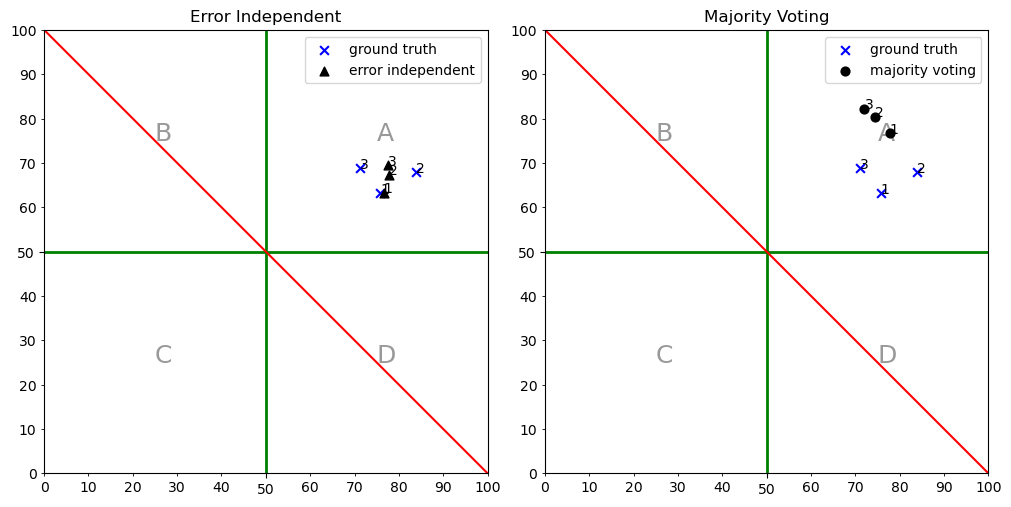

In [14]:
%matplotlib inline
from ntqr.r2.plots import compare_evaluations, plot_evaluations
mv_exact = majority_voting_eval.evaluation_exact
size=40
compare_evaluations([
    ["ground truth", 
     [d['a']*100 for d in seval_exact["accuracy"]],
     [d['b']*100 for d in seval_exact["accuracy"]],
      "x","b",size],
    ["error independent",
     [d['a']*100 for d in ae_eval[0]["accuracy"]],
     [d['b']*100 for d in ae_eval[0]["accuracy"]],
      "^", "k",size],
    ["majority voting",
     [d['a']*100 for d in mv_eval_exact[0]["accuracy"]],
     [d['b']*100 for d in mv_eval_exact[0]["accuracy"]],
      "o", "k",size],],0,
    titles=["Ground Truth","Error Independent", "Majority Voting"],figsize=(10,5),legend_loc="best",withArrows=False)

The results for the error-independent solution are better than majority voting. But let's take a look 

## Histograms of data sketch evaluations

### The histogram for the estimates of the 'a' label

Let's take a look at the prevalence estimates for these data sketches. The ground truth for the 'a' label is 9.2%.

In [22]:
# Let's collect all the evaluations using the error-independent evaluator
ae_estimates = [ntqr.ErrorIndependentEvaluation(ntqr.TrioLabelVoteCounts(ds).to_TrioVoteCounts()) for ds in data_sketches]
# The majority voting estimates
mv_estimates = [ntqr.MajorityVotingEvaluation(ntqr.TrioLabelVoteCounts(ds).to_TrioVoteCounts()) for ds in data_sketches]
# The ground truth evaluations - supervised evaluation
ground_truth = [ntqr.SupervisedEvaluation(ntqr.TrioLabelVoteCounts(ds)) for ds in data_sketches]

In [16]:
import matplotlib.pyplot as plt
# We are picking out the lowest prevalence solution for the 'a' label
prev_ae_estimates = [float(eval.evaluation_exact[0]["prevalence"]["a"]) for eval in ae_estimates]
prev_mv_estimates = [float(eval.evaluation_exact[0]["prevalence"]["a"]) for eval in mv_estimates]

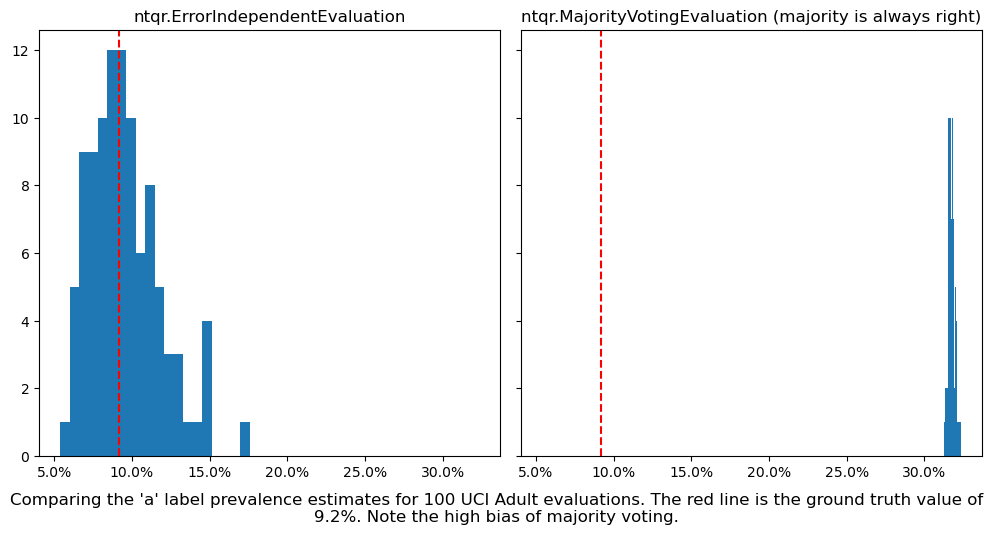

In [20]:
%matplotlib inline
from matplotlib.ticker import PercentFormatter
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, tight_layout=True,figsize=(10,5))
n_bins = 20
axs[0].hist(prev_ae_estimates, bins=n_bins)
axs[0].set_title("ntqr.ErrorIndependentEvaluation")
axs[0].axvline(0.092,color='r',linestyle='--')
axs[1].xaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[1].hist(prev_mv_estimates, bins=n_bins)
axs[1].set_title("ntqr.MajorityVotingEvaluation (majority is always right)")
axs[1].axvline(0.092,color='r',linestyle='--')
txt="""Comparing the 'a' label prevalence estimates for 100 UCI Adult evaluations. The red line is the ground truth value of 9.2%. Note the high bias of majority voting."""
plt.figtext(0.5,-0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


Wow. Majority voting (here we are showing the 'majority is right' solution) does very badly in these evaluations. What about the accuracy estimates for the classifiers? Let's plot the errors for both methods of evaluation - error-independent solution, majority voting is right.

### Histograms for the estimates of the label accuracies for the three classifiers

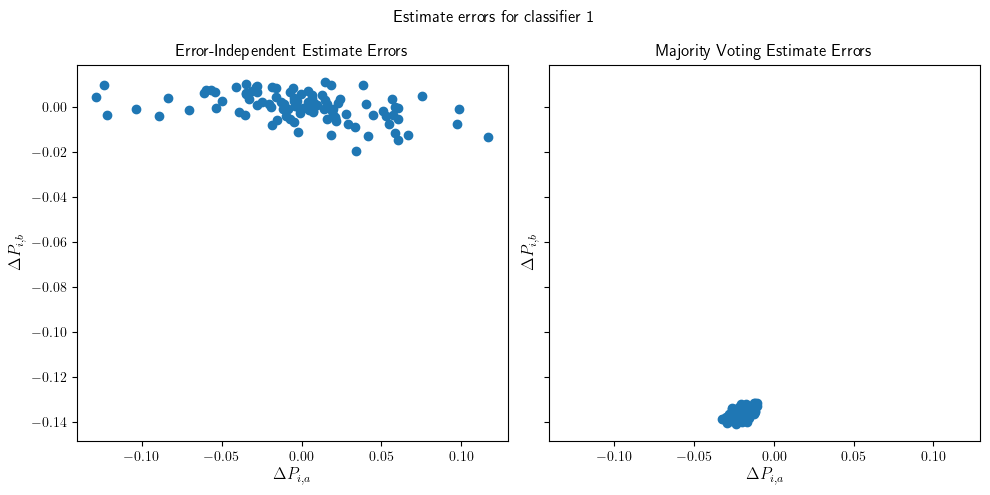

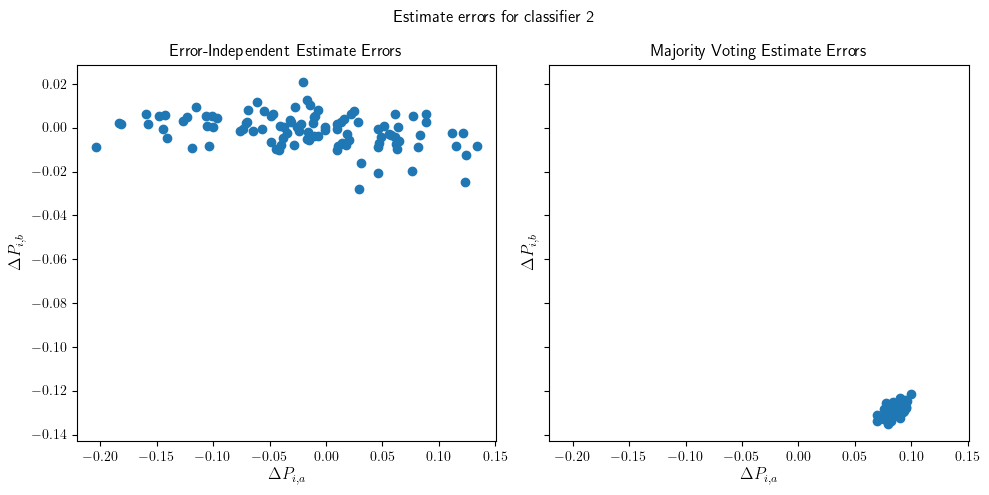

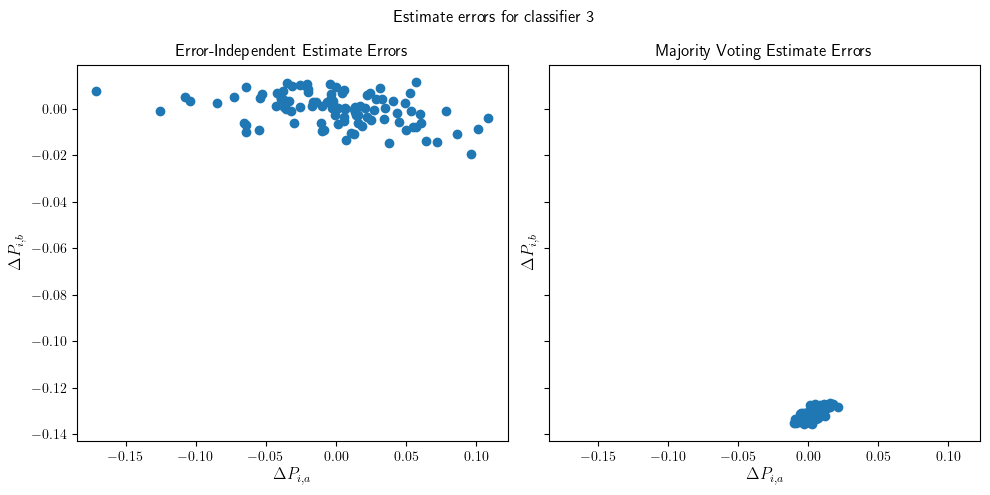

In [36]:
%matplotlib inline
plt.rcParams['text.usetex'] = True
for classifier in range(3):
    # The ground truth value for the accuracies
    pia_gt = [float(seval.evaluation_exact["accuracy"][classifier]["a"]) for seval in ground_truth]
    pib_gt = [float(seval.evaluation_exact["accuracy"][classifier]["b"]) for seval in ground_truth]
    # The estimates from using the error-independent solution
    pia_ae_estimates = [float(eval.evaluation_exact[0]["accuracy"][classifier]["a"]) for eval in ae_estimates]
    pib_ae_estimates = [float(eval.evaluation_exact[0]["accuracy"][classifier]["b"]) for eval in ae_estimates]
    # The majority voting estimates, we select the low 'a' prevalence solution. This corresponds to assuming
    # that the majority is always right.
    pia_mv_estimates = [float(eval.evaluation_exact[0]["accuracy"][classifier]["a"]) for eval in mv_estimates]
    pib_mv_estimates = [float(eval.evaluation_exact[0]["accuracy"][classifier]["b"]) for eval in mv_estimates]
    # Now calculate the errors
    error_ae_pia = [float(gt_val - ae_val) for gt_val, ae_val in zip(pia_gt, pia_ae_estimates)]
    error_ae_pib = [float(gt_val - ae_val) for gt_val, ae_val in zip(pib_gt, pib_ae_estimates)]
    #
    error_mv_pia = [float(gt_val - ae_val) for gt_val, ae_val in zip(pia_gt, pia_mv_estimates)]
    error_mv_pib = [float(gt_val - ae_val) for gt_val, ae_val in zip(pib_gt, pib_mv_estimates)]
    
    # The plot
    fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, tight_layout=True,figsize=(10,5))
    axs[0].scatter(error_ae_pia, error_ae_pib,)
    axs[0].set_xlabel(r"$\Delta P_{i,a}$",fontsize=12)
    axs[0].set_ylabel(r"$\Delta P_{i,b}$",fontsize=12)
    axs[0].set(title="Error-Independent Estimate Errors")
    axs[1].scatter(error_mv_pia, error_mv_pib,)
    axs[1].set_xlabel(r"$\Delta P_{i,a}$",fontsize=12)
    axs[1].set_ylabel(r"$\Delta P_{i,b}$",fontsize=12)
    axs[1].set(title="Majority Voting Estimate Errors")
    fig.suptitle("Estimate errors for classifier " + str(classifier+1))
    plt.show()


Wow, again. So why are not using the NTQR tools to help you monitor your deployed AI systems?